In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image


#for classification/regression tasks and training on data sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

#for training deep learning models with Pytorch (with images)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
#converts test submission, test data, training data, and target metadata name csvs to Pandas Dataframes
submission = pd.read_csv('/kaggle/input/planttraits2024/sample_submission.csv')
test_data = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
train_data =pd.read_csv('/kaggle/input/planttraits2024/train.csv')
target_name = pd.read_csv("/kaggle/input/planttraits2024/target_name_meta.tsv", delimiter='\t')

In [3]:
#define 'images_folder' as a string path to the kaggle competition train_images
images_folder = '/kaggle/input/planttraits2024/train_images/'

image_files = os.listdir(images_folder)

number_of_images = len(image_files)

# Print the count of images
print(f"Number of images in the training data set: {number_of_images}")

Number of images in the training data set: 55489


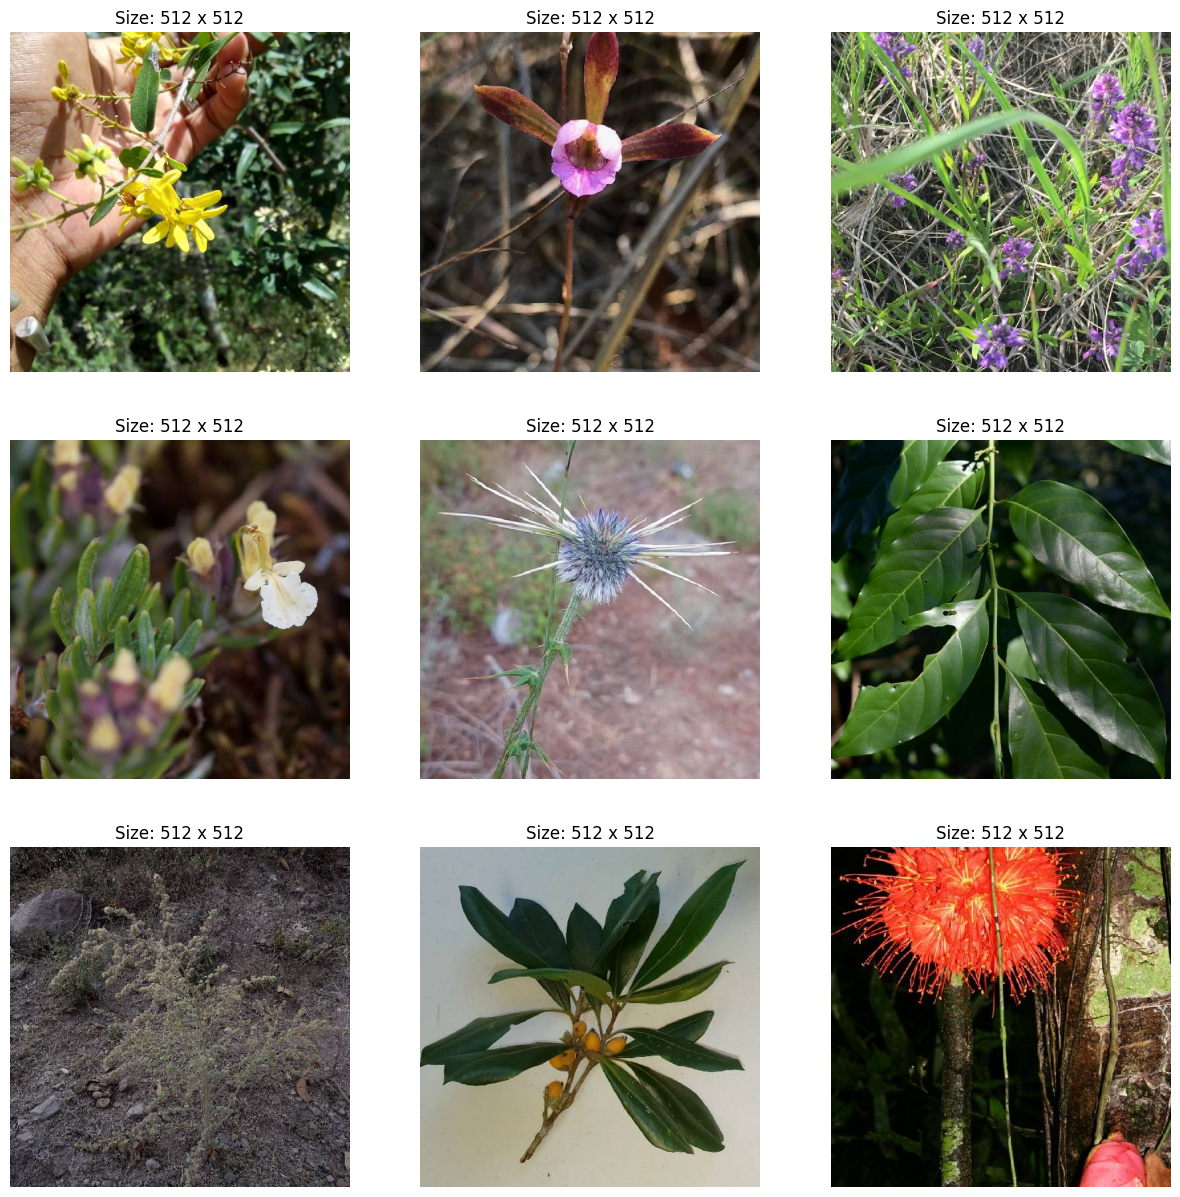

In [175]:
#select nine random image files
random_images = random.sample(image_files, 9)

#create a figure for displaying the images
plt.figure(figsize=(15, 15))#size of figure 

#loop through the selected images
for i, image_file in enumerate(random_images):
    # Construct the full image path
    image_path = os.path.join(images_folder, image_file)
    
    #pen the image
    img = Image.open(image_path)
    
    #get the size of the image
    original_size = img.size
    
    #add a subplot in a 3x3 grid
    plt.subplot(3, 3, i + 1)
    
    #display the image
    plt.imshow(img)
    
    #set the title of each subplot to the dimensions of the image
    plt.title(f"Size: {original_size[0]} x {original_size[1]}")

    plt.axis('off')

plt.show()


In [176]:
count_non_512 = 0

for image_file in image_files:
    # Construct the full image path
    image_path = os.path.join(images_folder, image_file)
    
    #tests the folowing code block for errors
    try:
        
        img = Image.open(image_path)
        
        #Check if the image size is not 512x512
        if img.size != (512, 512):
            count_non_512 += 1
    except IOError:
        # Handle the error if the file is not an image
        print(f"Cannot open {image_file}")

# Print the total number of images not 512x512
print(f"Number of images not 512x512: {count_non_512}")


Number of images not 512x512: 0


We have now verified that all pictures in the training dataset are the same dimensions.

In [4]:
#define 'images_folder' as a string path to the kaggle competition test_images
images_folder = '/kaggle/input/planttraits2024/test_images/'

image_files = os.listdir(images_folder)

number_of_images = len(image_files)

#print the# of images
print(f"Number of images in the test data set: {number_of_images}")

Number of images in the test data set: 7133


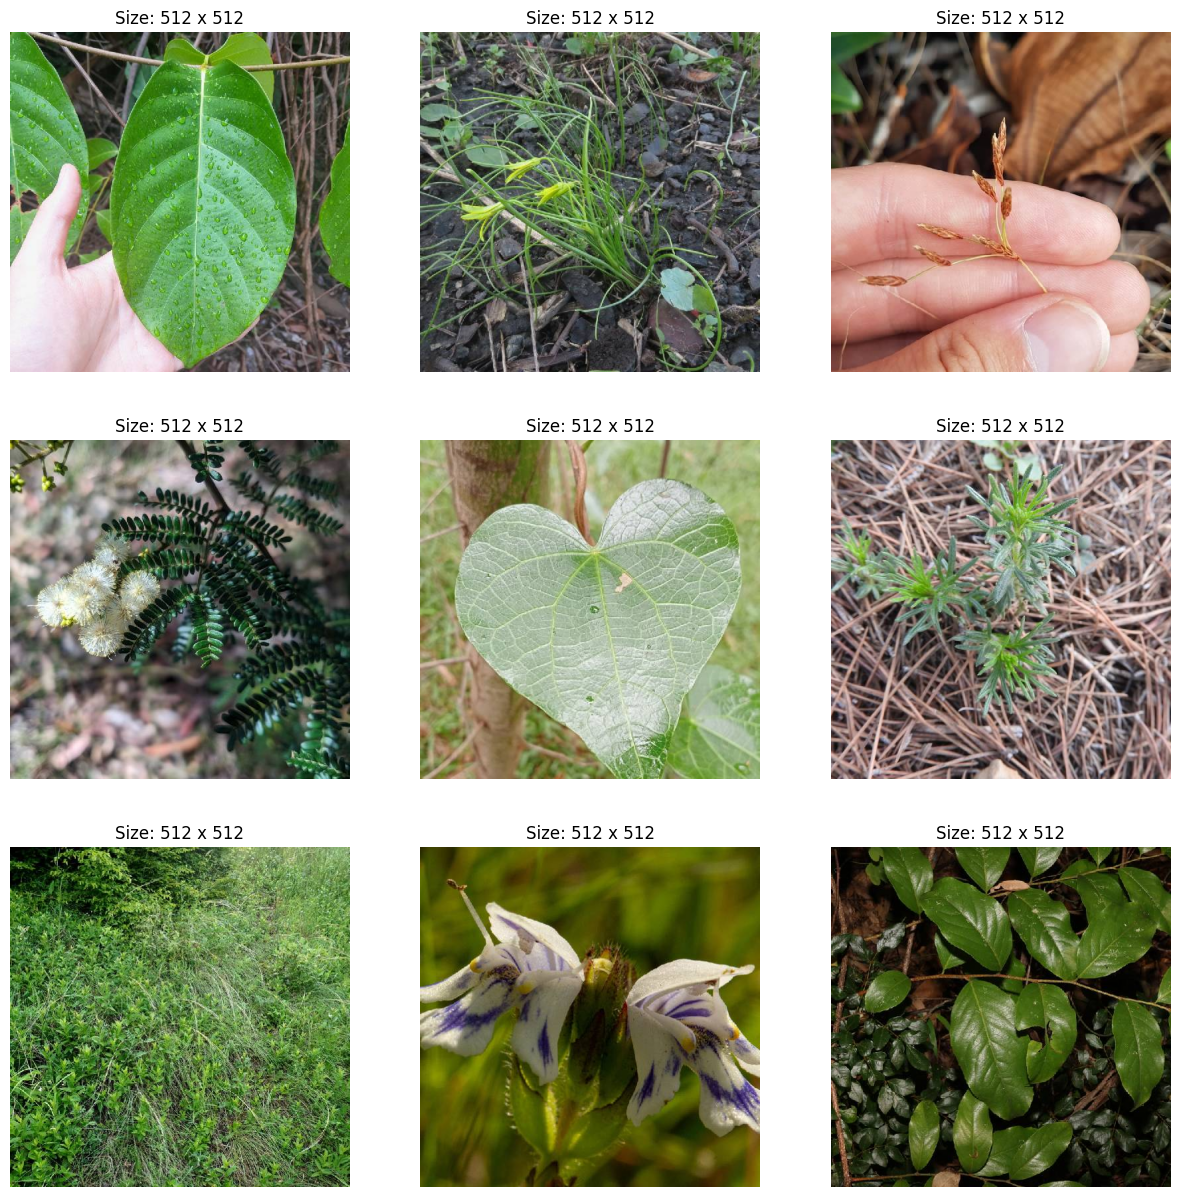

In [181]:
#select nine random image files
random_images = random.sample(image_files, 9)

#create a figure for displaying the images
plt.figure(figsize=(15, 15)) #size of figure 

#loop through the selected images
for i, image_file in enumerate(random_images):
    # Construct the full image path
    image_path = os.path.join(images_folder, image_file)
    
    #pen the image
    img = Image.open(image_path)
    
    #get the size of the image
    original_size = img.size
    
    #add a subplot in a 3x3 grid
    plt.subplot(3, 3, i + 1)
    
    #display the image
    plt.imshow(img)
    
    #set the title of each subplot to the dimensions of the image
    plt.title(f"Size: {original_size[0]} x {original_size[1]}")

    plt.axis('off')

plt.show()


In [182]:
count_non_512 = 0

for image_file in image_files:
    #construct the full image path
    image_path = os.path.join(images_folder, image_file)
    
    #tests the folowing code block for errors
    try:
        
        img = Image.open(image_path)
        
        #check if the image size is not 512x512
        if img.size != (512, 512):
            count_non_512 += 1
    except IOError:
        #handle the error if the file is not an image
        print(f"Cannot open {image_file}")

#print number of images not 512x512
print(f"Number of images not 512x512: {count_non_512}")


Number of images not 512x512: 0


We have now verified that the test data set includes only images that are 512x512 pixels. Since both our training and testing databases of images are the same size, we won't have to clean the images by resizing them.

In [5]:
#defines the r^2 function: the metric by which the competition will grade the predictions
def calculate_mean_r2(actual_values, predicted_values):
    residual_sum_of_squares = np.sum((actual_values - predicted_values) ** 2, axis=0)
    total_sum_of_squares = np.sum((actual_values - np.mean(actual_values, axis=0)) ** 2, axis=0)
    
    
    r2_scores = 1 - residual_sum_of_squares / (total_sum_of_squares + 1e-6)
    #added a small number, 1e-6, to the denominator to ensure we won't divide by 0
    
    mean_r2_score = np.mean(r2_scores)
    
    return mean_r2_score


Maximizing the R^2 value is the goal for our model, since the Kaggle competition will grade our submission based on that metric.

In [6]:
y_true_columns = train_data.filter(like='_mean').values

The cell above filters the "train_data" dataframe by any column containing the string 'mean.' These are going to be the y values for our prediction models, since these are the traits that we will be predicting

In [7]:
y_columns = [col for col in train_data.columns if col.endswith('_mean')]
X_columns = [col for col in train_data.columns if not col.endswith(('_sd', '_mean'))]

y = train_data[y_columns]
X = train_data[X_columns].drop(['id'], axis = 1)

In [ ]:
for target_col in y_columns:
    target = y[target_col]
    
    corr_matrix = X.corrwith(target)
    
    relevant_features = corr_matrix[abs(corr_matrix) >= 0.1]
    
    if len(relevant_features) == 0:
        print("No correlation greater than 0.1 for", target_col)
    else:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=relevant_features.values, y=relevant_features.index, orient='h')
        plt.title(f'Correlation {target_col}')
        plt.xlabel('X')
        plt.ylabel('Correlation')
        plt.show()

In [ ]:
#loops 
for target_col in y_columns:
    target = y[target_col]
    
    corr_matrix = X.corrwith(target)
    
    relevant_features = corr_matrix[abs(corr_matrix) >= 0.1]
    
    if len(relevant_features) == 0:
        print("No correlation greater than 0.1 for", target_col)
    else:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=relevant_features.values, y=relevant_features.index, orient='h')
        plt.title(f'Correlation {target_col}')
        plt.xlabel('X')
        plt.ylabel('Correlation')
        plt.show()

In [ ]:
for target_col in y_columns:
    print(f"Selecting top 10 features for target column: {target_col}")
    
    selector = SelectKBest(score_func=f_regression, k=10)
    X_selected = selector.fit_transform(X, y[target_col])

    selected_indices = selector.get_support(indices=True)
    
    selected_features = X.columns[selected_indices]
    print("Selected features:", selected_features)
    print()

In [8]:

cols = X.columns.tolist()

first_two_words = ['_'.join(col.split('_')[:2]) for col in cols]

sorted_cols = {}

for col,first_two_word in zip(cols,first_two_words):
    if first_two_word not in sorted_cols:
        sorted_cols[first_two_word]=[col]
        
    else:
        sorted_cols[first_two_word].append(col)
        
        
for first_two_word,cols in sorted(sorted_cols.items()):
    print(f'{first_two_word}:')
    for col in cols:
        print(f'  -{col}')


MODIS_2000.2020:
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11
  -MODIS_2000.2020_monthly_mean_surface_reflectance_

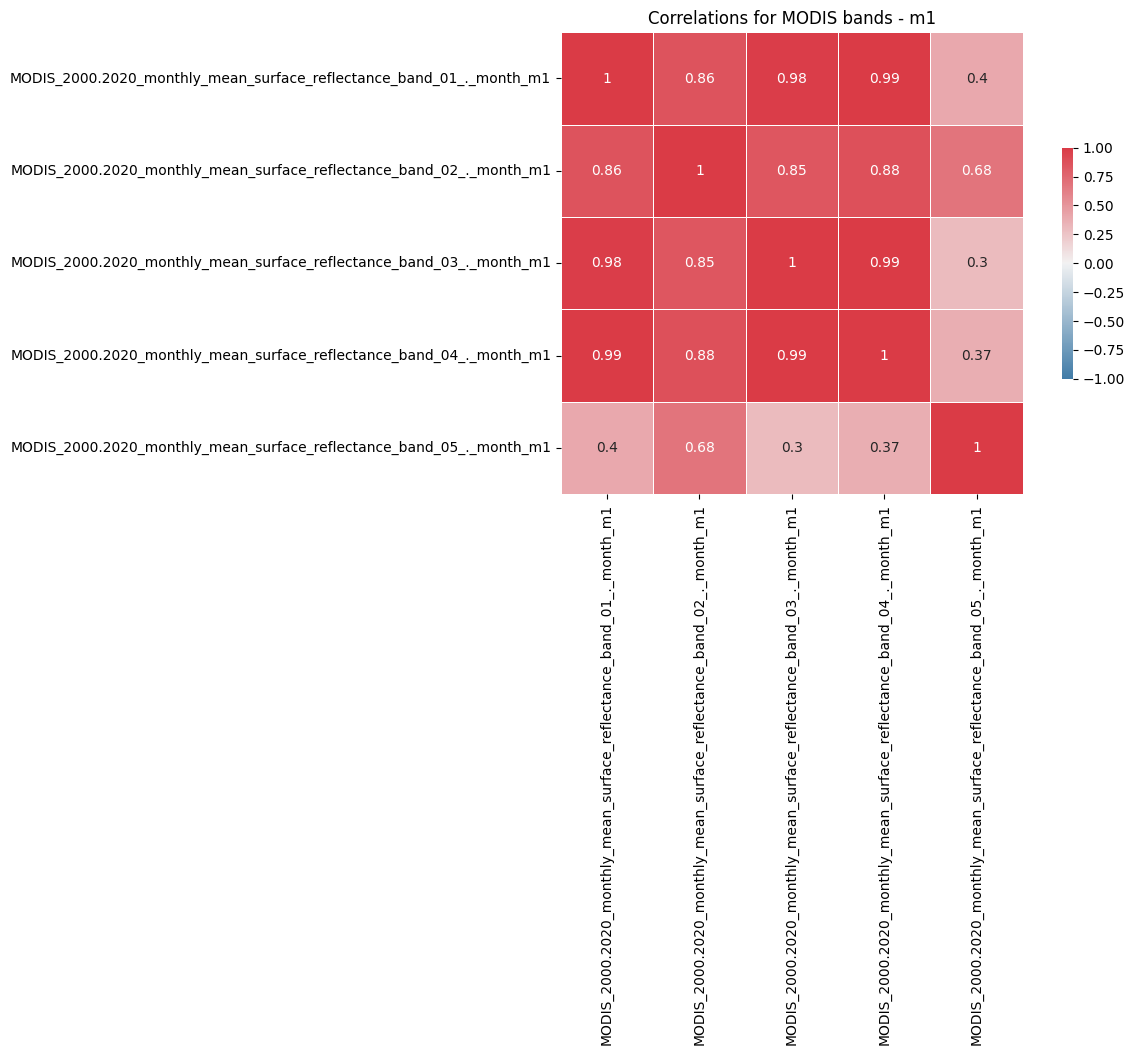

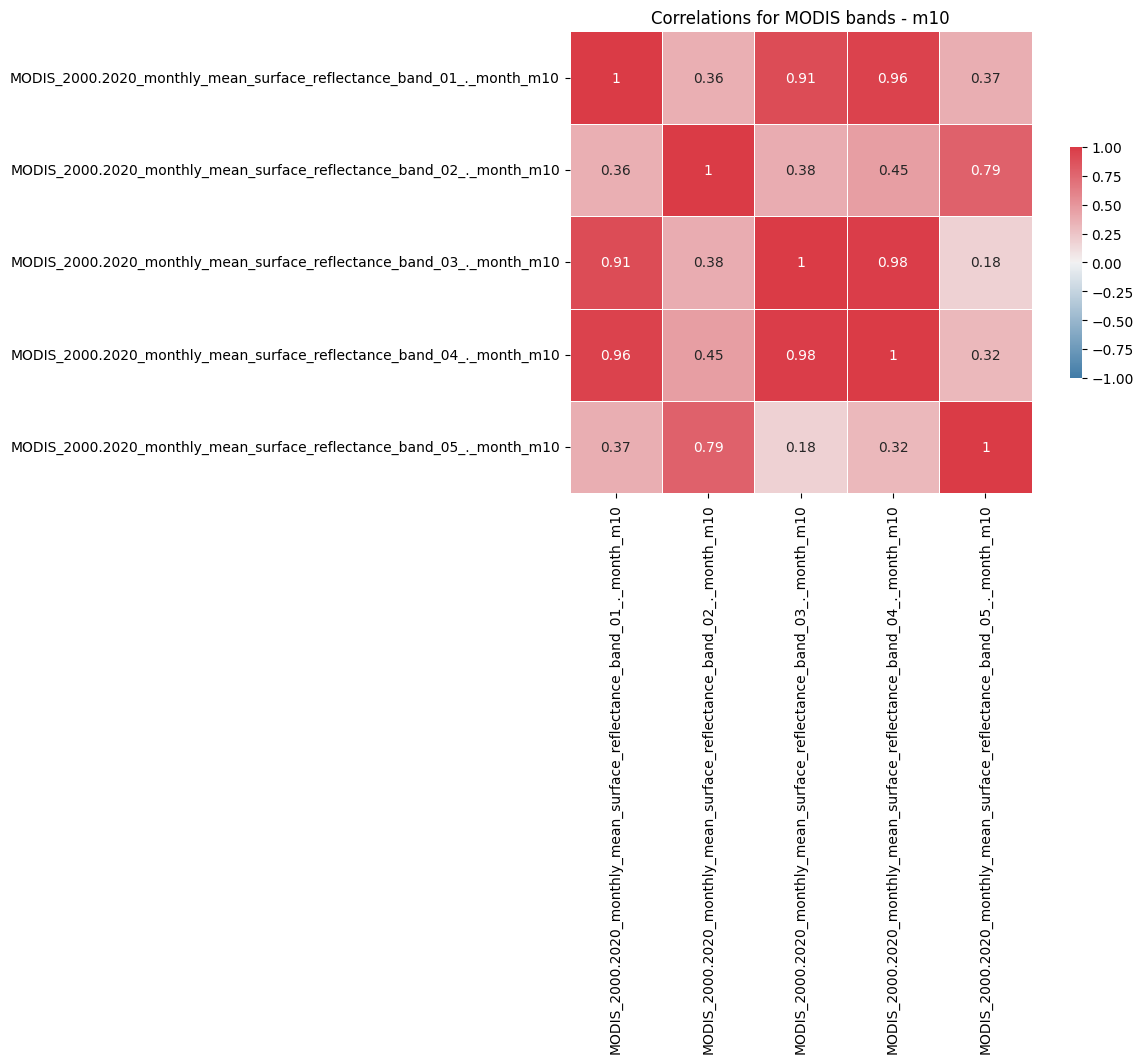

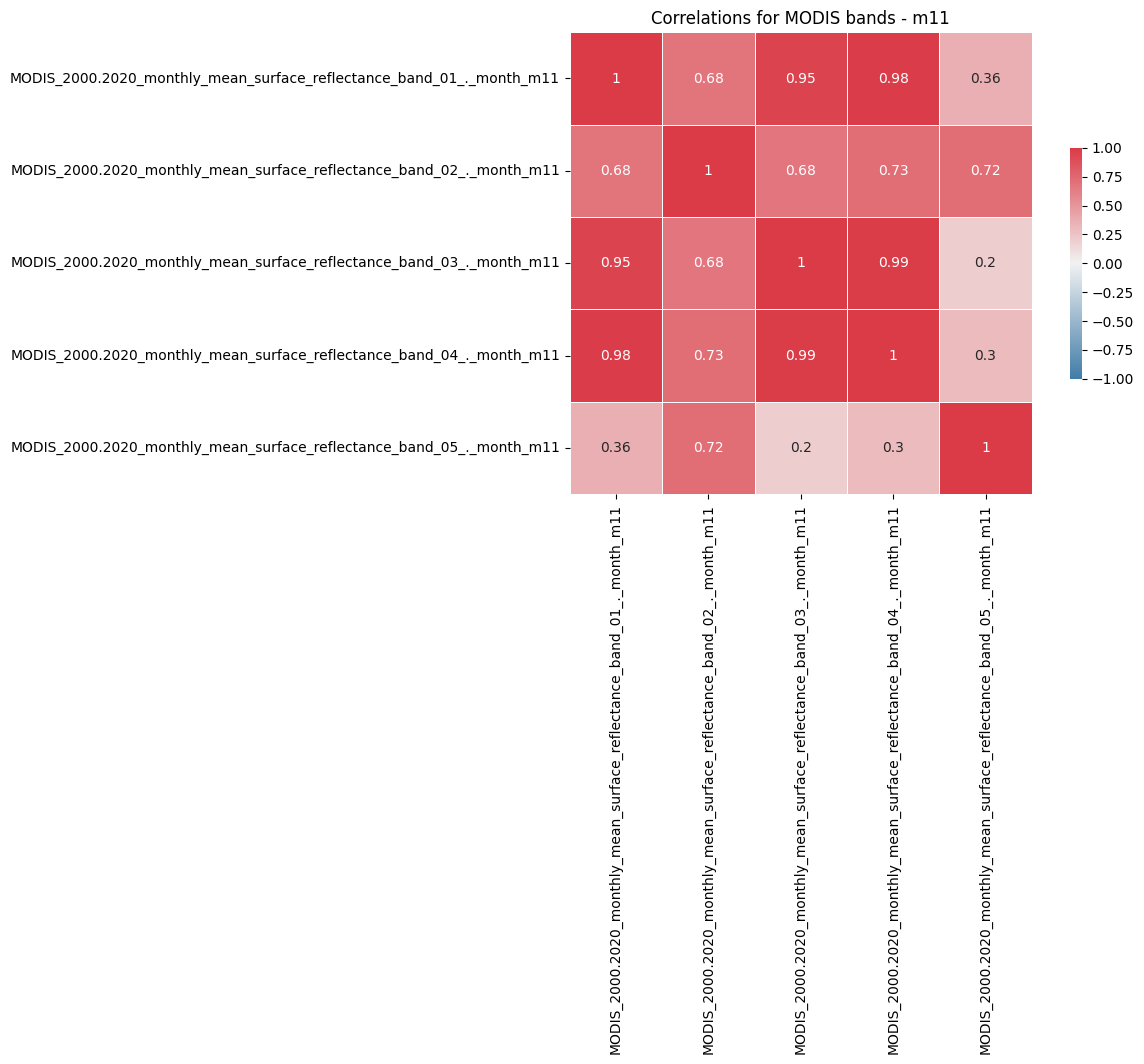

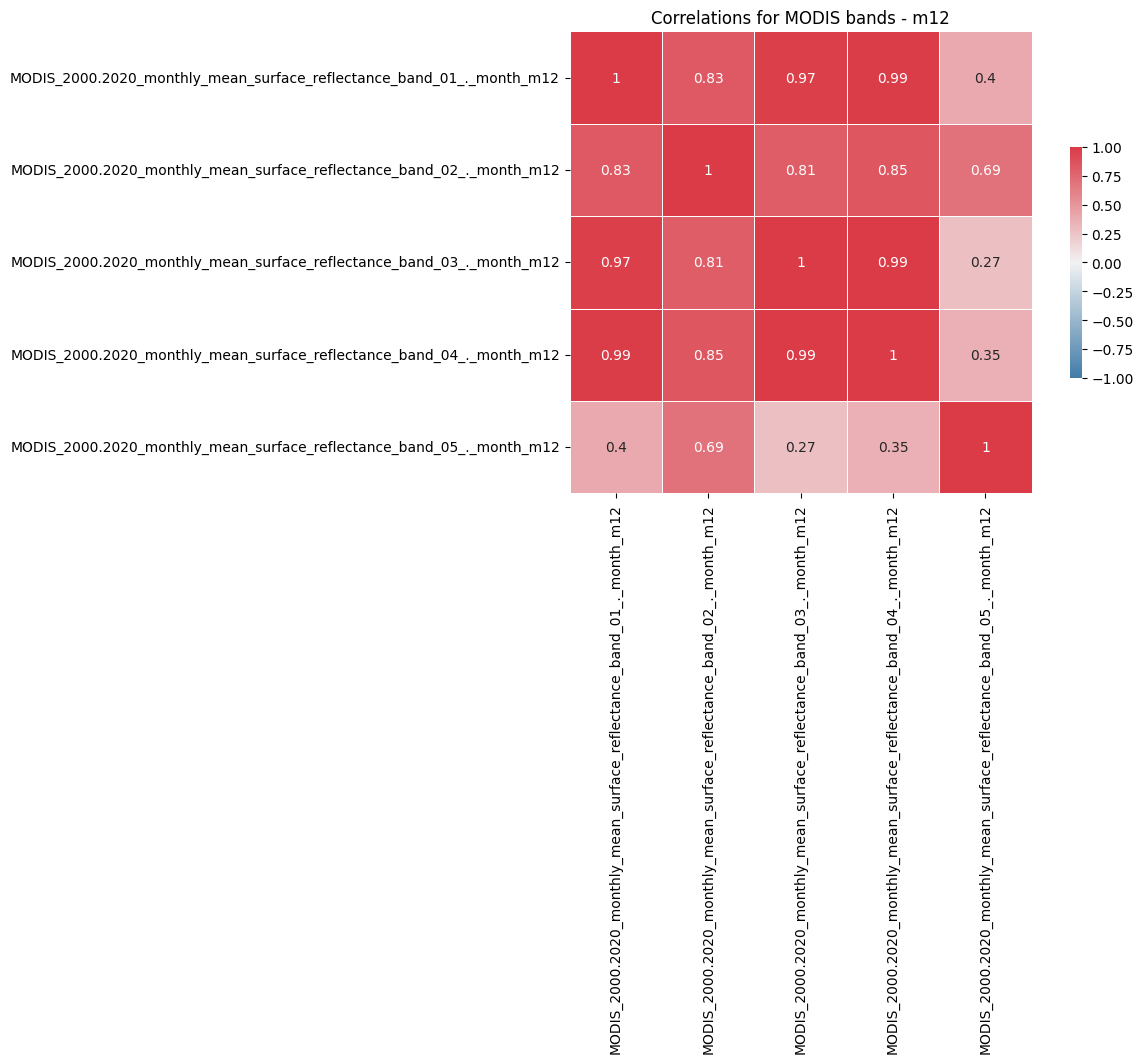

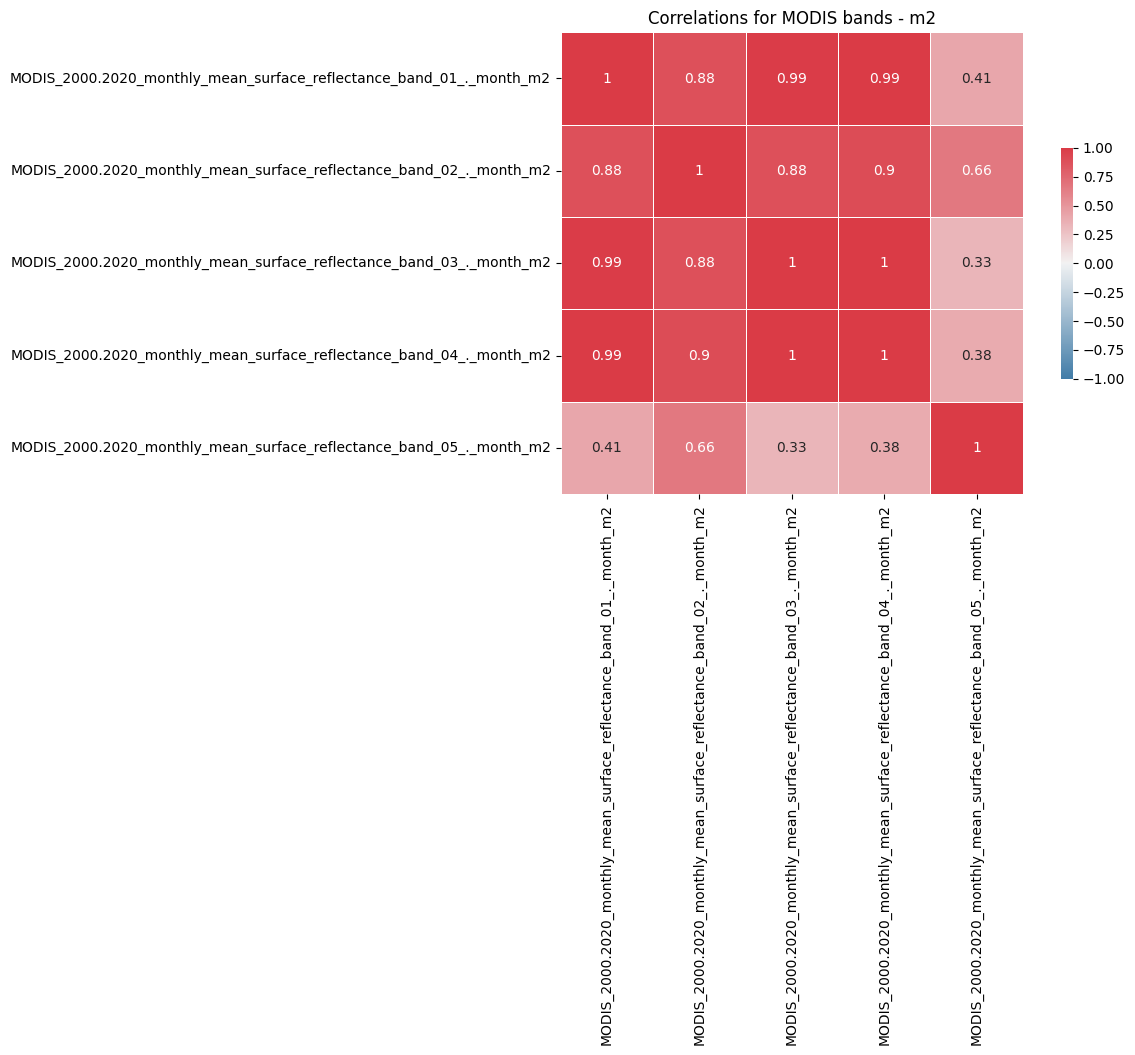

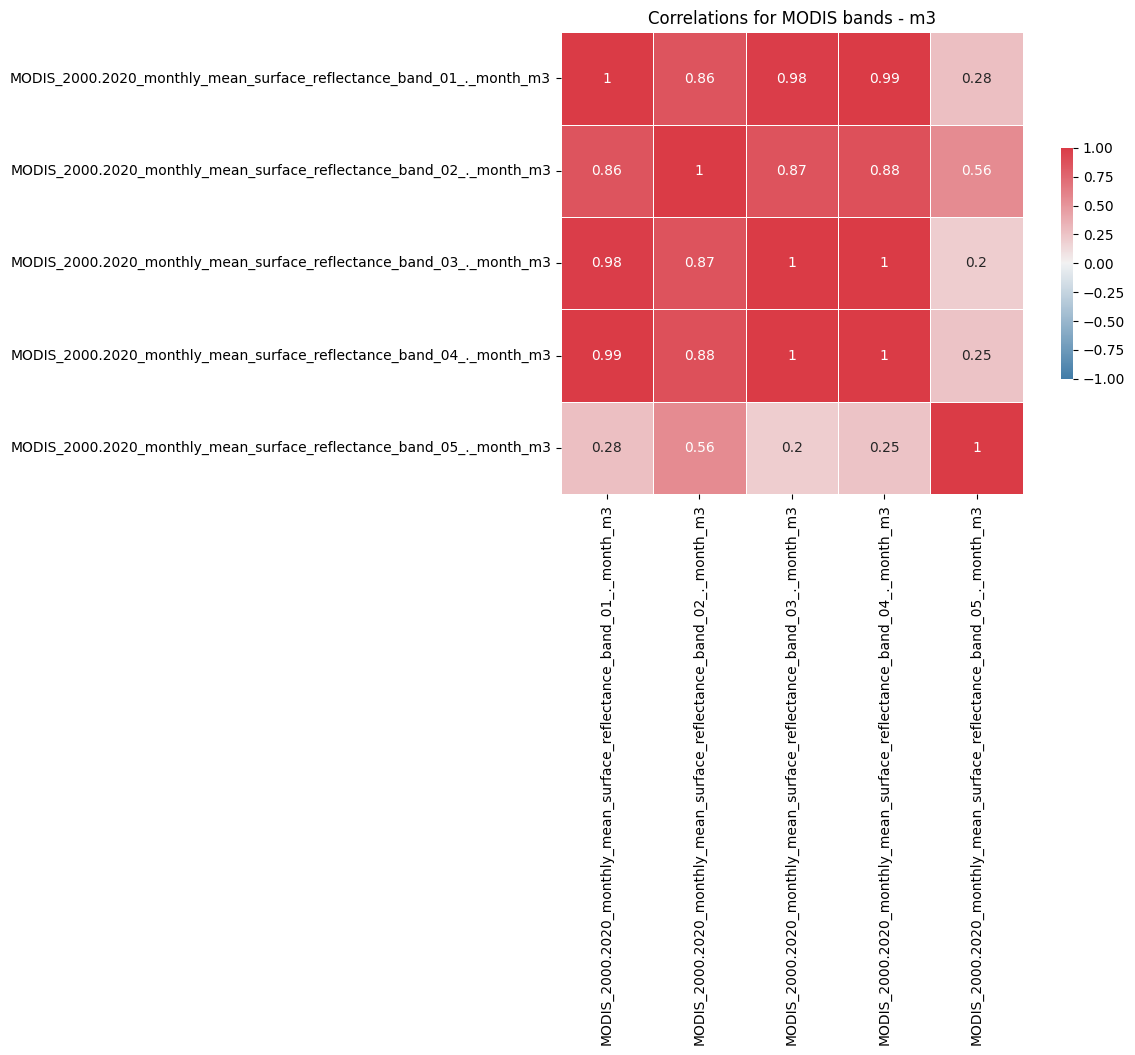

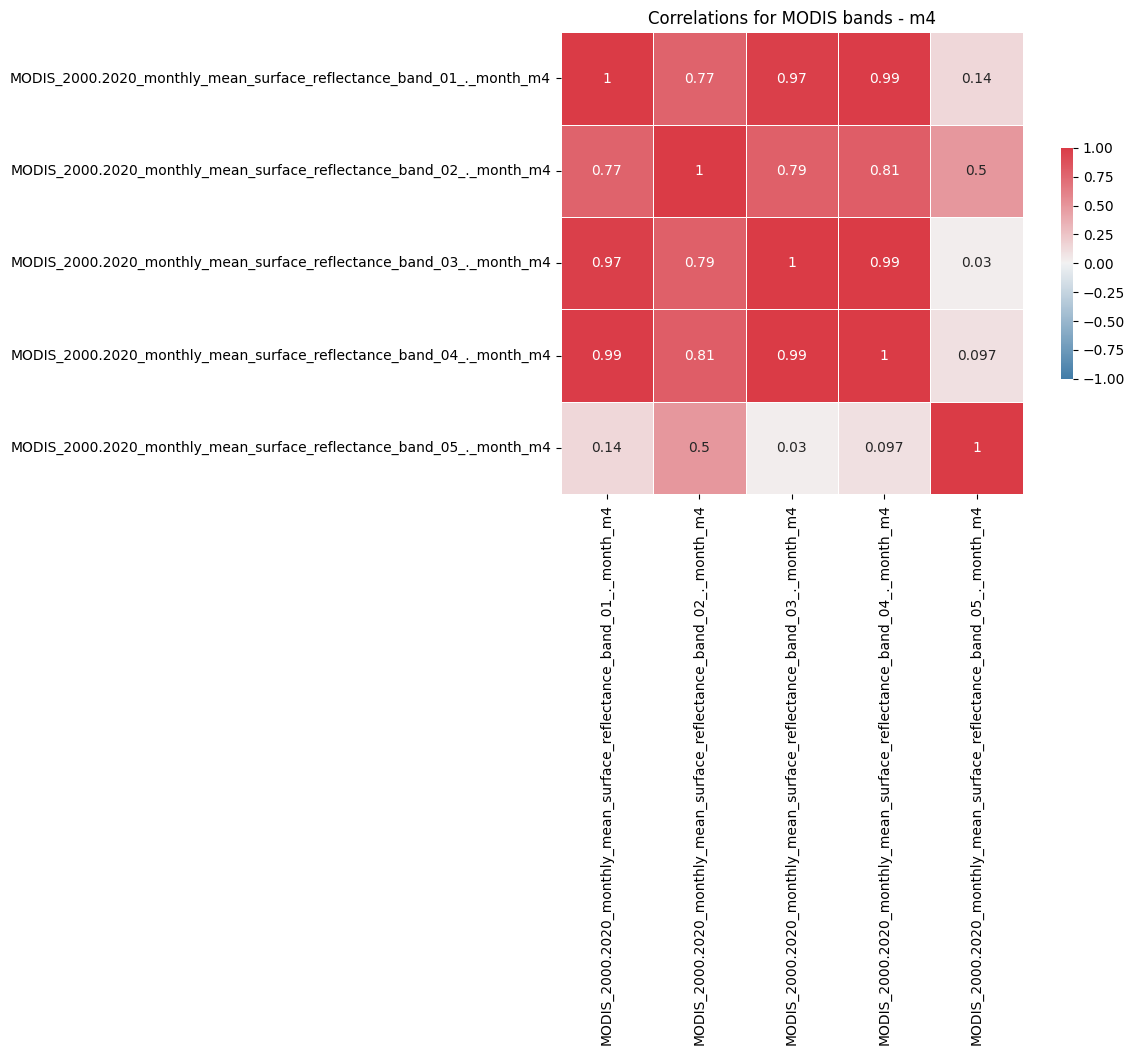

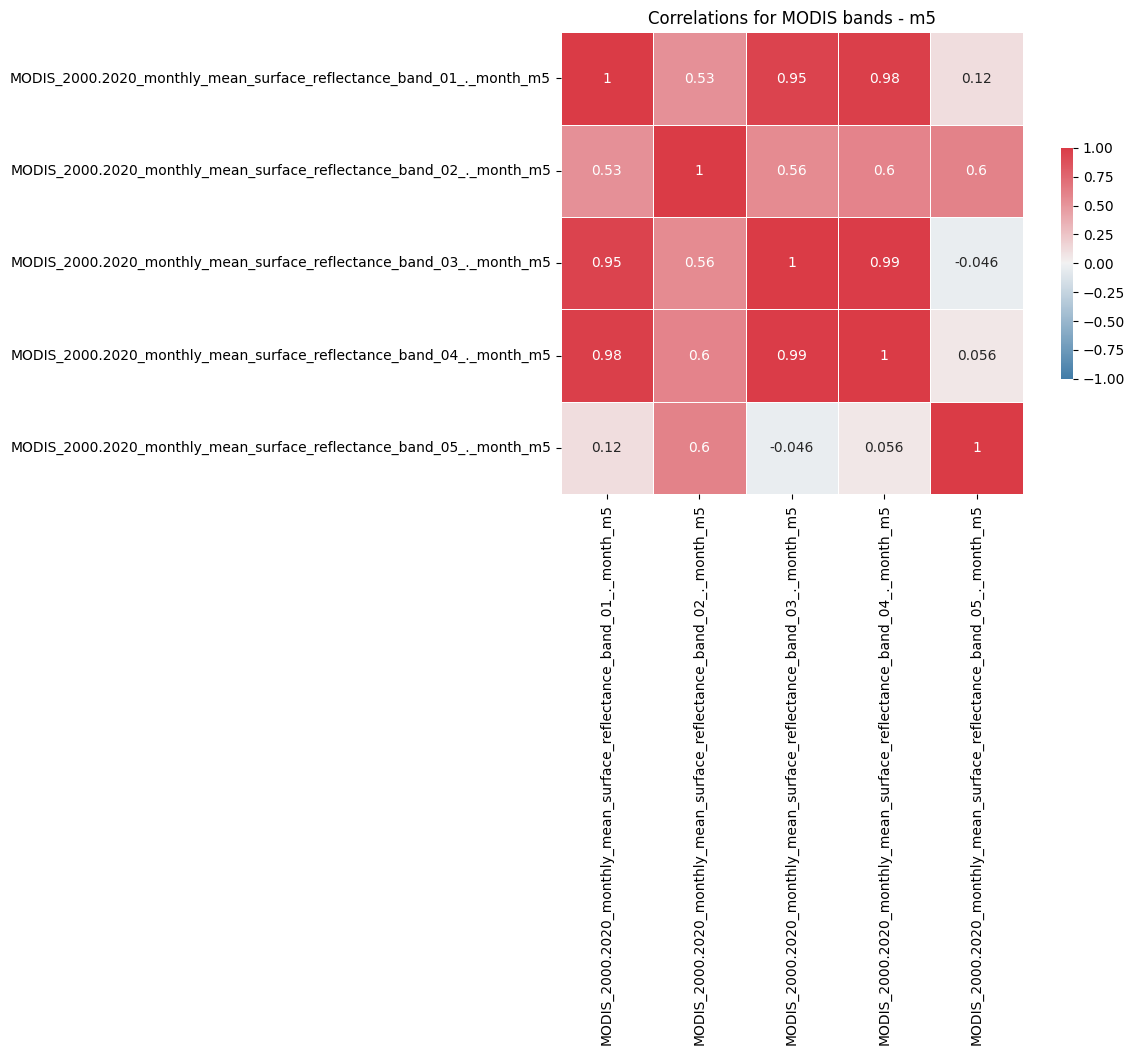

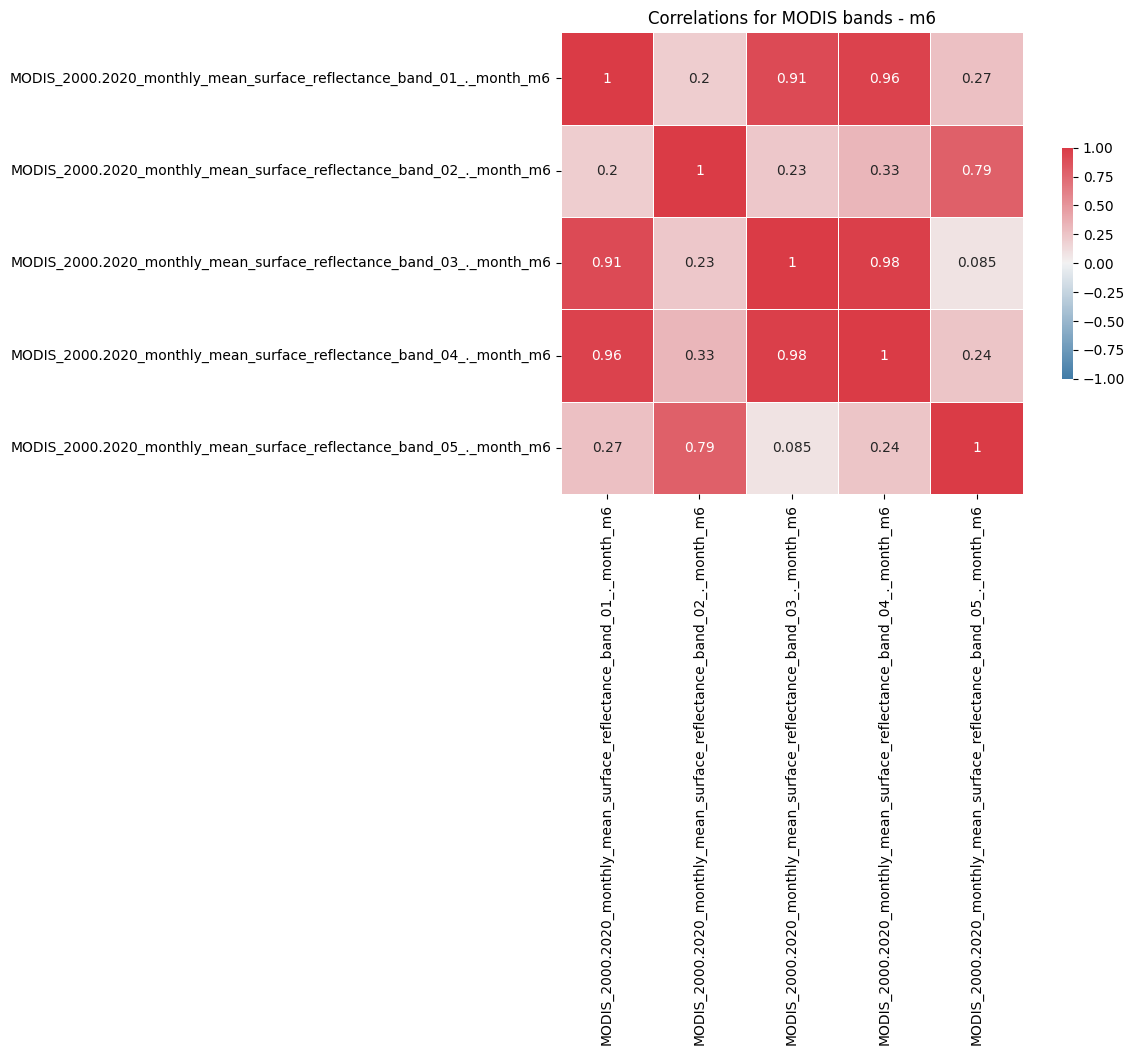

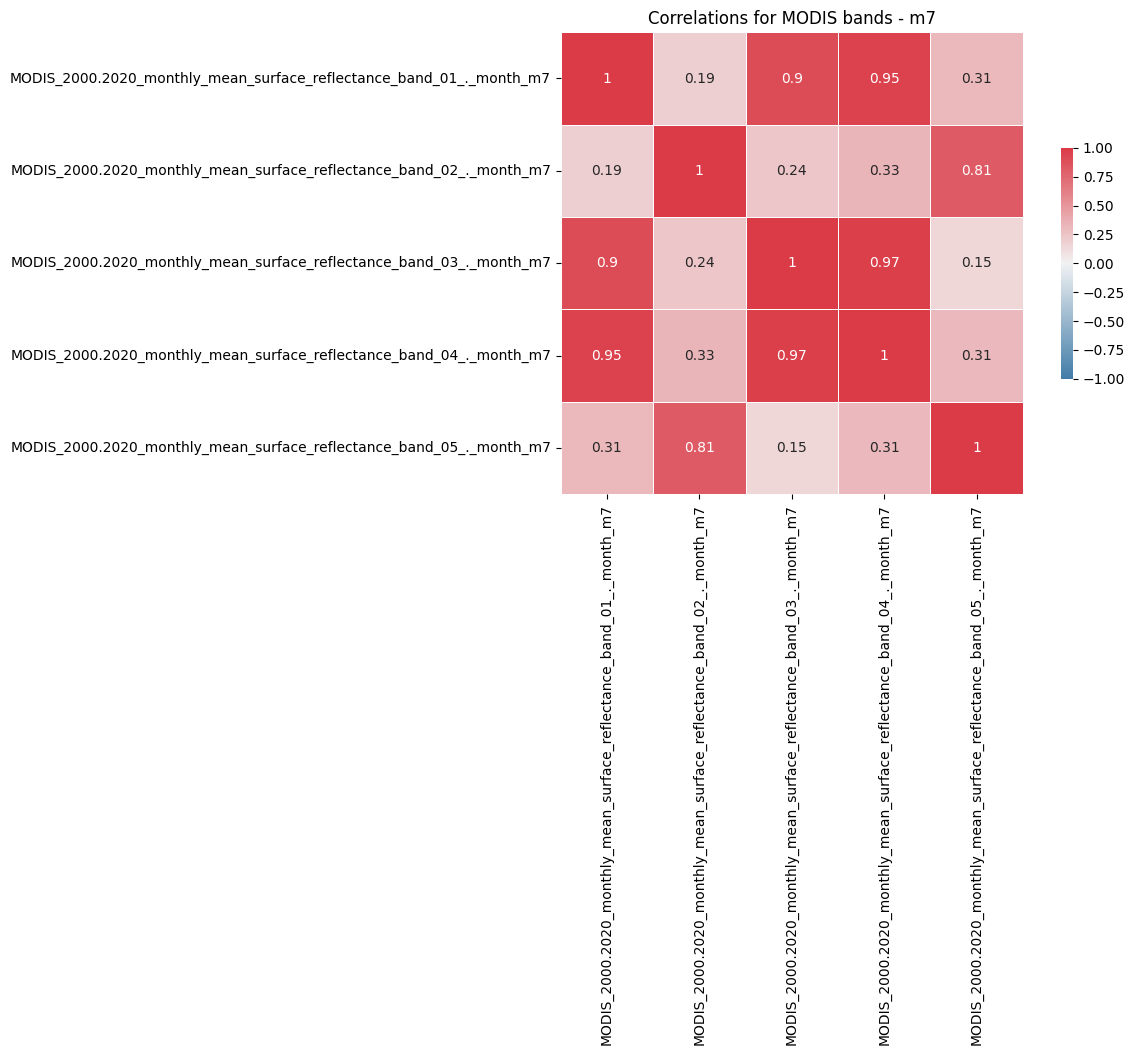

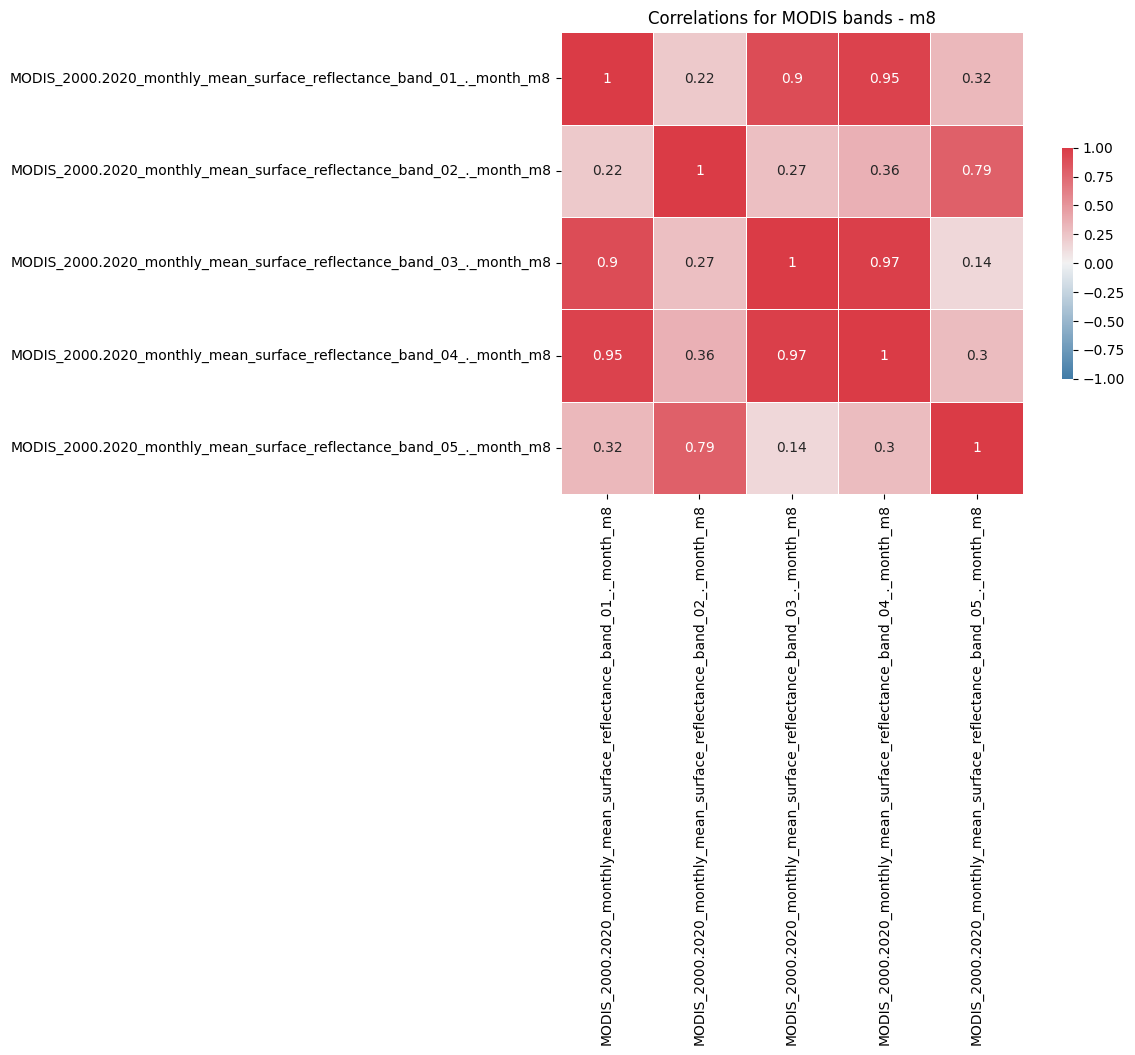

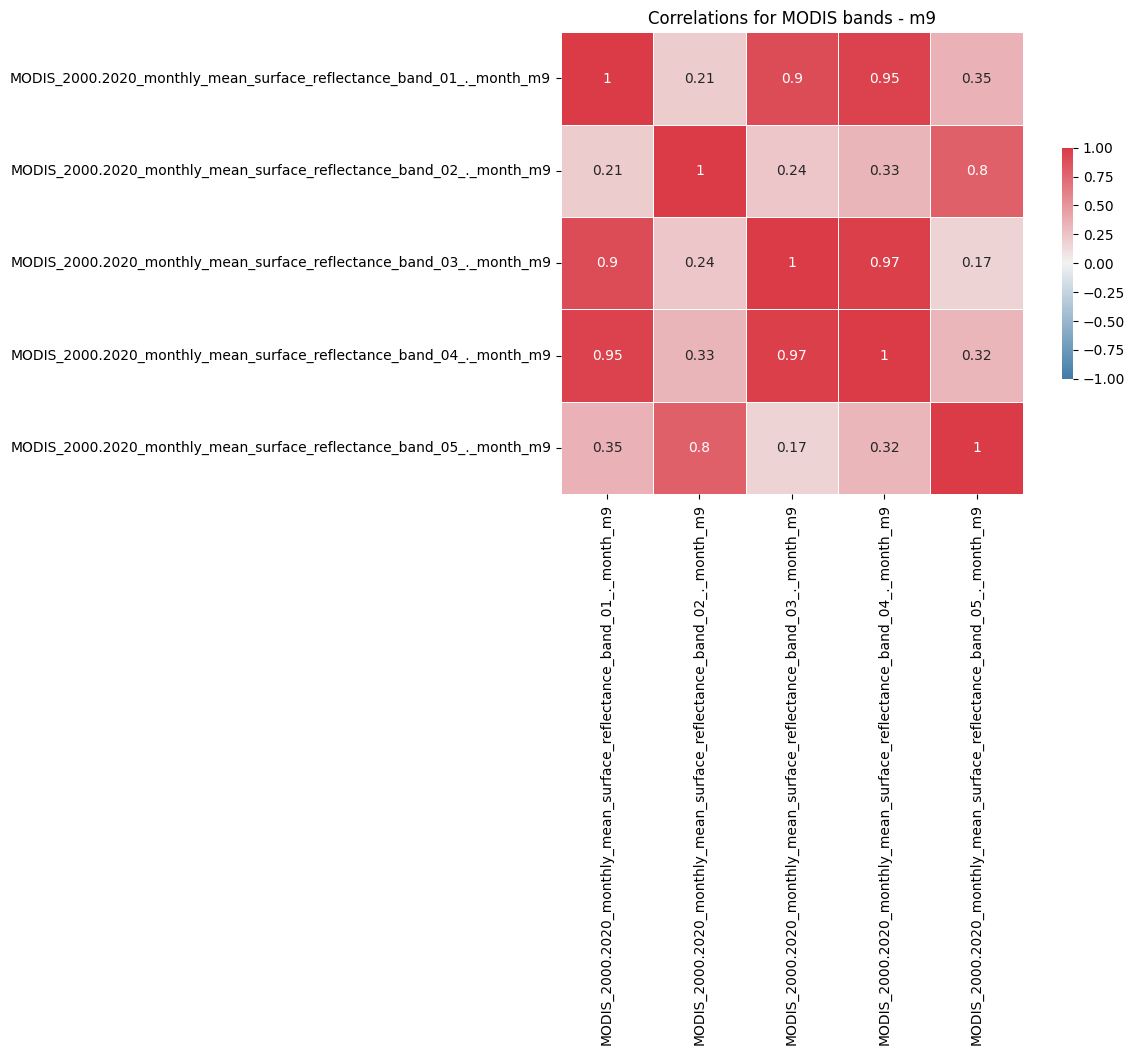

In [11]:
groups = {}

for col in X.columns:
    if col.startswith('MODIS_'):
        month = col.split('_')[-1]
        if month in groups:
            groups[month].append(col)
        else: 
            groups[month]=[col]
        
#Generate a correlation plot for each group
for month,cols in groups.items():
    corr_matrix = X[cols].corr(method='pearson')
    mask = (corr_matrix.abs()>0.7)

    
    plt.figure(figsize=(10, 6))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
    plt.title(f"Correlations for MODIS bands - {month}")
    plt.show()

In [12]:
filtered_columns = {key: val for key, val in sorted_cols.items() if 1 < len(val) <= 30}

for group_name, group_columns in filtered_columns.items():
    X[f'{group_name}_mean_features'] = X[group_columns].mean(axis=1)

In [13]:

for month, cols in groups.items():
    X_group = X[cols]
    scaler = StandardScaler()
    X_group_normalized = scaler.fit_transform(X_group)

    pca = PCA(n_components=1)
    X_group_pca = pca.fit_transform(X_group_normalized)
    X_group_pca = pd.DataFrame(X_group_pca, columns=[f'{month}_PCA_features'])

    X = pd.concat([X, X_group_pca], axis=1)


In [14]:

desired_columns = [
    'WORLDCLIM_BIO1_annual_mean_temperature',
    'WORLDCLIM_BIO12_annual_precipitation',
    'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
    'WORLDCLIM_BIO15_precipitation_seasonality',
    'WORLDCLIM_BIO4_temperature_seasonality'
]

features_columns = [col for col in X.columns if col.endswith('_features')]


selected_columns = desired_columns + features_columns

X = X[selected_columns]


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
class R2Loss(torch.nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_true, y_pred):
        SS_res = torch.sum((y_true - y_pred)**2, axis=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, axis=0))**2, axis=0)
        r2_loss = SS_res / (SS_tot + 1e-6)
        return torch.mean(r2_loss)
    
class R2Metric(torch.nn.Module):
    def __init__(self):
        super(R2Metric, self).__init__()
        self.SS_res = torch.zeros(6).to(device)
        self.SS_tot = torch.zeros(6).to(device)
        self.num_samples = torch.zeros(6).to(device)

    def update_state(self, y_true, y_pred):
        SS_res = torch.sum((y_true - y_pred)**2, axis=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, axis=0))**2, axis=0)
        self.SS_res += SS_res
        self.SS_tot += SS_tot
        self.num_samples += y_true.shape[0]

    def forward(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return torch.mean(r2)
    
    def reset_states(self):
        self.SS_res = torch.zeros(6).to(device)
        self.SS_tot = torch.zeros(6).to(device)
        self.num_samples = torch.zeros(6).to(device)

In [ ]:
class Regressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, output_size)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x

In [ ]:
scaler_data = StandardScaler()
X_train_scaled = scaler_data.fit_transform(X_train)
X_val_scaled = scaler_data.transform(X_val)

train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train.values).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val_scaled).float(), torch.tensor(y_val.values).float())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Regressor(input_size=X_train.shape[1], output_size=6).to(device)
criterion = R2Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [179]:
import matplotlib.pyplot as plt

num_epochs = 10
train_r2_values = []
val_r2_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_samples_train = 0
    r2_metric.reset_states()  # Resetting the R-squared metric for each epoch
   
    for x_batch, y_batch in train_loader:
        # Training steps...
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(y_batch, outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        r2_metric.update_state(y_batch, outputs)
        total_samples_train += y_batch.size(0)

    train_r2 = r2_metric()
    train_r2_values.append(train_r2)
   
    model.eval()
    total_val_loss = 0
    total_samples_val = 0
    r2_metric.reset_states()
   
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            # Validation steps...
            outputs = model(x_batch)
            val_loss = criterion(y_batch, outputs)
            total_val_loss += val_loss.item()
            r2_metric.update_state(y_batch, outputs)
            total_samples_val += y_batch.size(0)

    val_r2 = r2_metric()
    val_r2_values.append(val_r2)
   
    print(f"Epoch [{epoch+1}/{num_epochs}], Train R^2: {train_r2:.4f}, Val R^2: {val_r2:.4f}")

# Plotting
epochs = range(1, num_epochs+1)
train_r2_values_np = [r2.detach().numpy() for r2 in train_r2_values]
val_r2_values_np = [r2.detach().numpy() for r2 in val_r2_values]

plt.plot(epochs, train_r2_values_np, label='Train R^2')
plt.plot(epochs, val_r2_values_np, label='Validation R^2')
plt.xlabel('Epochs')
plt.ylabel('R^2 Value')
plt.title('R^2 Value vs. Epochs')
plt.legend()
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
num_epochs=10
r2_metric = R2Metric().to(device)


for epoch in range(num_epochs):
    model.train()
    total_loss=0
    total_r2_train=0
    total_samples_train=0
    
    
    for x_batch,y_batch in train_loader:
        x_batch,y_batch = x_batch.to(device),y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(y_batch,outputs)
        loss.backward()
        optimizer.step()
        total_loss +=loss.item()
        
        
        r2_metric.update_state(y_batch,outputs)
        total_samples_train+=y_batch.size(0)
        
        
    train_r2 = r2_metric()
    r2_metric.reset_states()
    
    
    model.eval()
    total_val_loss=0
    total_r2_val=0
    total_samples_val=0
    
    
    
    
    with torch.no_grad():
        for x_batch,y_batch in val_loader:
            x_batch,y_batch = x_batch.to(device),y_batch.to(device)
            outputs = model(x_batch)
            val_loss = criterion(y_batch,outputs)
            total_val_loss += val_loss.item()
            r2_metric.update_state(y_batch,outputs)
            total_samples_val += y_batch.size(0)
            
            
        val_r2 = r2_metric()
        r2_metric.reset_states()
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.4f}, Train R^2: {train_r2:.4f}, Val Loss: {total_val_loss/len(val_loader):.4f}, Val R^2: {val_r2:.4f}")

In [ ]:
submission = pd.DataFrame({'id': test_data['id']})

In [ ]:
for group_name, group_columns in filtered_columns.items():
    test_data[f'{group_name}_mean_features'] = test_data[group_columns].mean(axis=1)
    
for month, cols in groups.items():
    test_group = test_data[cols]
    scaler = StandardScaler()
    test_group_normalized = scaler.fit_transform(test_group)

    pca = PCA(n_components=1)
    test_group_pca = pca.fit_transform(test_group_normalized)
    test_group_pca = pd.DataFrame(test_group_pca, columns=[f'{month}_PCA_features'])

    # Dodaj nowe kolumny PCA do ramki danych X
    test_data = pd.concat([test_data, test_group_pca], axis=1)
    
    features_columns = [col for col in X.columns if col.endswith('_features')]


selected_columns = desired_columns + features_columns

test_data = test_data[selected_columns]

In [ ]:
test_data_scaled = scaler_data.transform(test_data)
test_data_scaled_tensor = torch.tensor(test_data_scaled).float().to(device)

model.eval()
with torch.no_grad():
    predictions = model(test_data_scaled_tensor)
prediction_columns = ['X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
    
for i, col in enumerate(prediction_columns):
    submission[col] = predictions[:, i].cpu().numpy()
    
submission = submission[['id', 'X4', 'X11', 'X18', 'X50', 'X26', 'X3112']]
submission.to_csv('submission1.csv', index=False)
submission